### Visualizing Responses

In [38]:
import matplotlib.pyplot as plt
import numpy as np

X = np.load('X_data.npy', mmap_mode='r')
y = np.load('Y_data.npy', mmap_mode='r')



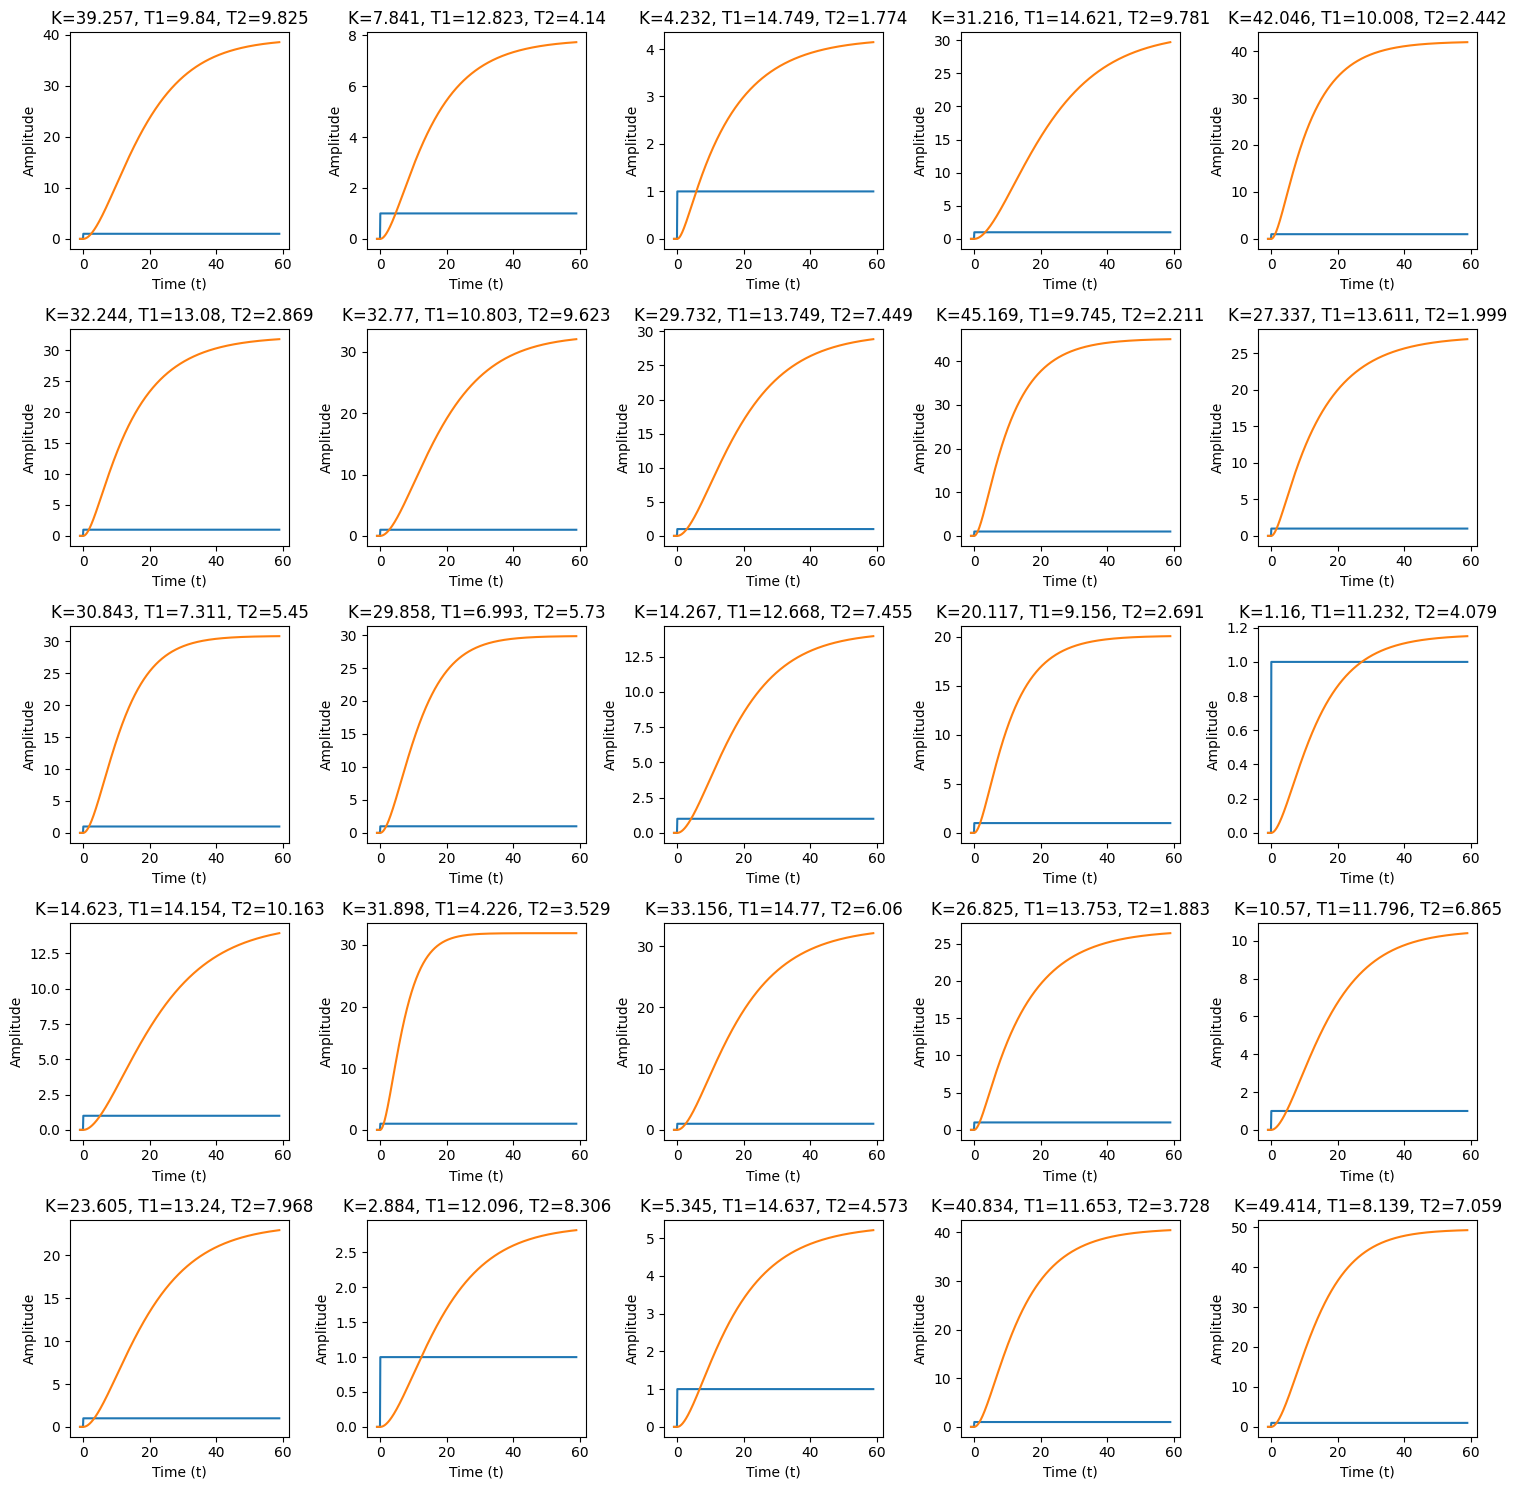

In [39]:
# ...existing code...
responses = X[0:25]
fig, axes = plt.subplots(nrows= 5, ncols=5, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
    t = responses[i][:, 2]
    x_e = responses[i][:, 0]
    x_a = responses[i][:, 1]
    K = y[i][0]
    T1 = y[i][1]
    T2 = y[i][2]
    ax.plot(t, x_e, label='x_e')
    ax.plot(t, x_a, label='x_a')
    ax.set_title(f'K={K}, T1={T1}, T2={T2}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Amplitude')

plt.tight_layout() # Adjust subplot params for a tight layout
plt.show() # Display the figure

### Parameters

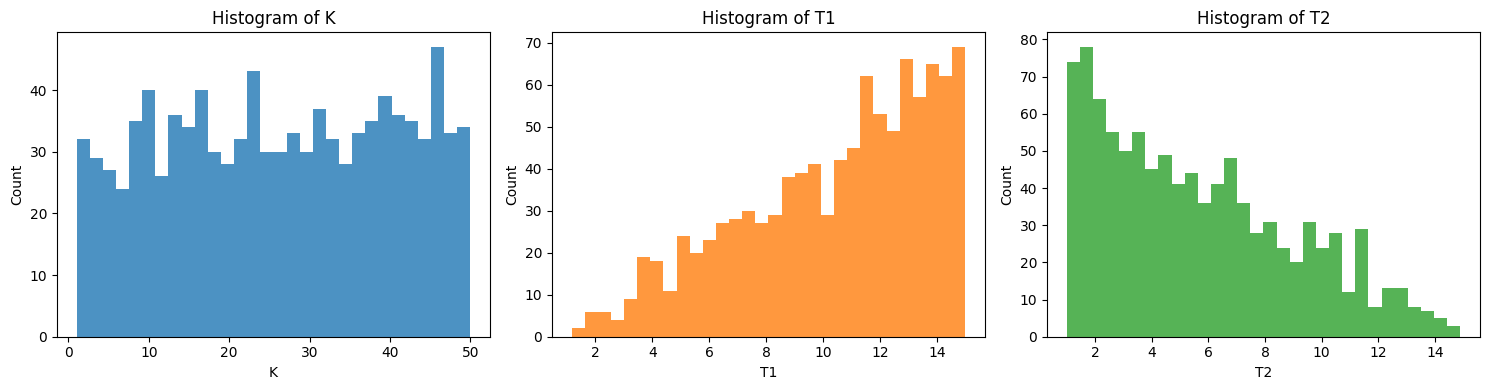

In [40]:
import numpy as np
import matplotlib.pyplot as plt

y = np.asarray(y, dtype=float)  # ensure numeric array, shape (N,3)

labels = ['K', 'T1', 'T2']
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, ax in enumerate(axes):
    ax.hist(y[:, i], bins=30, color=f'C{i}', alpha=0.8)
    ax.set_title(f'Histogram of {labels[i]}')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### Distributions

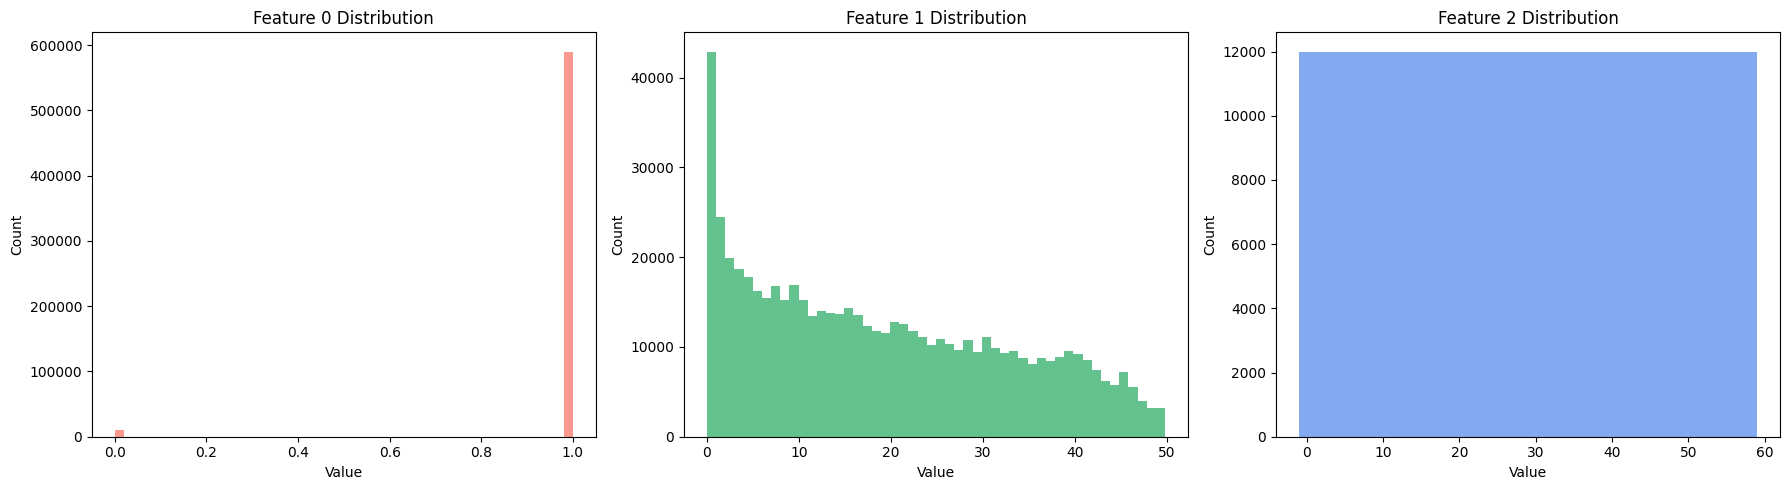

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['salmon', 'mediumseagreen', 'cornflowerblue']
labels = ['Feature 0', 'Feature 1', 'Feature 2']

for i in range(0,3):
  feat = X[:,:,i].flatten()
  # print(feat) # Commenting out print to avoid large output
  axes[i].hist(feat, bins=50, color=colors[i], alpha=0.8)
  axes[i].set_title(f'{labels[i]} Distribution')
  axes[i].set_xlabel('Value')
  axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### TRAINING MODEL

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if len(physical_devices) > 0:
    print(f"Device Name: {physical_devices[0].name}")
else:
    print("⚠️ No GPU found. Training will run on CPU.")

random_state = 42

Num GPUs Available:  0
⚠️ No GPU found. Training will run on CPU.


### Preprocessing

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Reshape X_train and X_test for StandardScaler
# StandardScaler expects a 2D array: (n_samples, n_features)
# Here, each 'sample' will be a single time step from all experiments, so we flatten the first two dimensions.
num_samples_train, time_steps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)

num_samples_test, _, _ = X_test.shape
X_test_reshaped = X_test.reshape(-1, num_features)

# Initialize and fit StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_reshaped) # Fit on training data only

# Transform both training and testing data
X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

# Reshape back to original 3D shape (num_samples, time_steps, num_features) for Conv1D
X_train_scaled = X_train_scaled_reshaped.reshape(num_samples_train, time_steps, num_features)
X_test_scaled = X_test_scaled_reshaped.reshape(num_samples_test, time_steps, num_features)

print(f"Original X shape: {X.shape}")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Original X shape: (1000, 600, 3)
X_train_scaled shape: (800, 600, 3)
X_test_scaled shape: (200, 600, 3)
y_train shape: (800, 3)
y_test shape: (200, 3)


In [47]:
# 1. Define the Model Architecture
model = Sequential()

# Convolutional Layer: 32 filters, kernel size of 3
# input_shape ignores the batch size (1000), so it is (600, 3)
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(600, 3)))
# Pooling Layer: Downsample by taking the max value in a window of 2
model.add(MaxPooling1D(pool_size=2))
# Flatten Layer: Convert the 2D matrix to a 1D vector
model.add(Flatten())
# Hidden Dense Layer: Intermediate processing
model.add(Dense(64, activation='relu'))

# Output Layer: 3 neurons for the 3 regression targets
# We use 'relu' here to ensure predictions are always positive
model.add(Dense(3, activation='relu'))
# 2. Compile the Model
# Optimizer: Adam is a standard, efficient choice
# Loss: Mean Squared Error (MSE) for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

NameError: name 'y_train_scaled' is not defined